In [178]:
import pandas as pd
import numpy as np

np.random.seed(2718)
pd.set_option('display.max_columns', None)

## Import and Prepare the Data

In [179]:
df = pd.read_parquet('hmda.parquet')
# We will create different dataset splits below because we will need three splits: train, valid, and scale  
df.drop(columns=['train'])

,low_priced,interest_rate,rate_spread,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,state_target_encoded,product_type_conventional,product_type_fha,product_type_fsa_rhs,product_type_va,Black,Asian/PI,White,Native American,Hispanic,Non-Hispanic,Male,Female,Age >= 62,Age < 62,race,ethnicity,sex
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5897023,0.0,0.05250,0.017410,235000.0,1.0110,1,0,235000.0,81000.0,0.46,1.0,1.0,0.078974,0,1,0,0,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,0.0,1.0,Unknown,Hispanic,Unknown
1879906,1.0,0.04875,0.009960,55000.0,1.0101,1,0,55000.0,36000.0,0.25,1.0,1.0,0.087045,0,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,White,Non-Hispanic,Female
1862043,1.0,0.04875,0.006810,265000.0,1.0000,1,0,265000.0,102000.0,0.36,1.0,1.0,0.090457,1,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,NaN,NaN,White,Non-Hispanic,Female
4589390,1.0,0.03750,-0.002060,395000.0,0.8000,1,0,485000.0,200000.0,0.49,1.0,1.0,0.172242,1,0,0,0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,White,Unknown,Unknown
4342060,1.0,0.03875,0.004997,205000.0,0.8000,1,0,265000.0,49000.0,0.44,0.0,1.0,0.078002,1,0,0,0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,NaN,NaN,Unknown,Non-Hispanic,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41834,1.0,0.02990,0.009530,305000.0,0.7439,0,12,415000.0,153000.0,0.33,1.0,1.0,0.087719,1,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,White,Non-Hispanic,Unknown
3790562,0.0,0.04500,0.015330,305000.0,0.9650,1,0,305000.0,113000.0,0.49,1.0,1.0,0.119708,0,1,0,0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,White,Non-Hispanic,Unknown
4280451,1.0,0.04750,0.003420,165000.0,0.3137,1,0,515000.0,65000.0,0.41,1.0,1.0,0.065950,1,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,White,Non-Hispanic,Unknown


AIF 360 cannot handle missing values for protected class, so we are only going to use Black and white applicants to train the data. This means that the dataset used for model building will be quite a bit smaller than the available data.

In [180]:
df = df.loc[(df['Black'] == 1) | (df['White'] == 1), :]

Adding (Black = 1) column to the index, which AIF360 will use to identify the protected class

In [181]:
df['Black'] = df['Black'].astype(int)
df['White'] = df['White'].astype(int)
df.set_index('Black', inplace=True, append=True, drop=False)

Creating logs of highly skewed features for use in the DNN

In [183]:
log_features = ['loan_amount', 'property_value', 'income']
df[log_features] = np.log(df[log_features].clip(1))

Determining the train/validation/scaling splits for use in model building

In [184]:
from sklearn.model_selection import train_test_split
train, vs = train_test_split(df, test_size=0.3, random_state=61803)
valid, scale = train_test_split(vs, test_size=0.15, random_state=31415)
print(
    f"Training Dataset Size:   {train.shape[0]:0,.0f}"
    f"\nValidation Dataset Size: {valid.shape[0]:0,.0f}"
    f"\nScaling Dataset Size:    {scale.shape[0]:0,.0f}"
)

Training Dataset Size:   164,890
Validation Dataset Size: 60,067
Scaling Dataset Size:    10,601


In [185]:
label = 'low_priced'
features = [
    'loan_amount', 'loan_to_value_ratio', 'no_intro_rate_period',
    'intro_rate_period', 'property_value', 'income',
    'debt_to_income_ratio', 'term_360', 'conforming', 
    'state_target_encoded', 'product_type_conventional', 
    'product_type_fha', 'product_type_fsa_rhs', 'product_type_va',
]

Min-Max scale features (scaling is necessary for a DNN) 

In [186]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train[features])

MinMaxScaler()

In [187]:
train[features] = scaler.transform(train[features])
valid[features] = scaler.transform(valid[features])
scale[features] = scaler.transform(scale[features])

In [188]:
valid[features].agg(['min', 'max', 'std'])

,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,state_target_encoded,product_type_conventional,product_type_fha,product_type_fsa_rhs,product_type_va
min,0.000000,0.000948,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
max,0.957888,0.390423,1.000000,1.000000,0.901653,0.975065,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
std,0.075125,0.027503,0.204543,0.059937,0.069712,0.063946,0.16698,0.186978,0.234346,0.240297,0.471489,0.397339,0.16517,0.311656


## Create Helper Functions

In [189]:
def make_dnn_preds(dnn_model, data):
    return pd.Series(
        data=dnn_model.predict_proba(data)[:, 1],
        index=data.index
    )

In [190]:
from sklearn import metrics

def get_aucs(train_pred, valid_pred):
    auc_train = metrics.roc_auc_score(train[label], train_pred)
    auc_valid = metrics.roc_auc_score(valid[label], valid_pred)
    pct_change = auc_valid / auc_train - 1
    
    print(f'AUC Train:     {auc_train:.4f}')
    print(f'AUC Valid:     {auc_valid:.4f}')
    print(f'AUC % Change: {pct_change:.2%}')

In [191]:
def get_logloss(train_pred, valid_pred):
    logloss_train = metrics.log_loss(train[label], train_pred)
    logloss_valid = metrics.log_loss(valid[label], valid_pred)
    pct_change = logloss_valid / logloss_train - 1

    print(f'Log-Loss Train:    {logloss_train:.4f}')
    print(f'Log-Loss Valid:    {logloss_valid:.4f}')
    print(f'Log-Loss % Change: {pct_change:.2%}')

In [192]:
def get_race_logloss(train_pred, valid_pred):
    logloss_train = metrics.log_loss(train['Black'], train_pred)
    logloss_valid = metrics.log_loss(valid['Black'], valid_pred)
    
    print(f'Black Log-Loss Train:    {logloss_train:.4f}')
    print(f'Black Log-Loss Valid:    {logloss_valid:.4f}')

In [193]:
import solas_disparity as sd
import plotly.io as pio
pio.renderers.default = "png"

def calculate_quantile_air(group_data, prediction):
    qair = sd.adverse_impact_ratio_by_quantile(
        group_data=group_data,
        protected_groups=['Black'],
        reference_groups=['White'],
        group_categories=['Race'],
        air_threshold=0.90,
        percent_difference_threshold=0,
        outcome=prediction,
        quantiles=[x / 100 for x in range(5, 101, 5)],
        merge_bins=False,
        lower_score_favorable=False,
    )
    return qair

In [194]:
def calculate_smd(group_data, prediction):
    smd = sd.standardized_mean_difference(
        group_data=group_data,
        protected_groups=['Black'],
        reference_groups=['White'],
        group_categories=['Race'],
        smd_threshold=-30,
        outcome=prediction,
        lower_score_favorable=False,
    )
    smd_columns = [
        'Average Outcome', 'Difference in Average Outcome',
        'Std. Dev. of Outcomes', 'SMD', 'Practically Significant',
    ]
    return smd.summary_table[smd_columns]

In [195]:
import tensorflow.compat.v1 as tf
from aif360.sklearn.inprocessing import AdversarialDebiasing
from sklearn.calibration import CalibratedClassifierCV

# tf.disable_eager_execution()
tf.compat.v1.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

def build_model(params, calibration=False):
    # Creating the AIF360 AdversarialDebiasing Model:
    dnn = AdversarialDebiasing(
        **params,
        prot_attr='Black', 
        random_state=61803,
    )
    dnn = dnn.fit(X=train[features], y=train[label])

    # Platt Scale Calibration:
    if calibration:
        calibrated_dnn = CalibratedClassifierCV(
            estimator=dnn, 
            method='sigmoid', 
            cv='prefit'
        ) 
        calibrated_dnn.fit(X=scale[features], y=scale[label])
        train_pred = make_dnn_preds(calibrated_dnn, train[features])
        valid_pred = make_dnn_preds(calibrated_dnn, valid[features])

    else:
        train_pred = make_dnn_preds(dnn, train[features])
        valid_pred = make_dnn_preds(dnn, valid[features])

    return dnn, train_pred, valid_pred

In [196]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
def ks_plot(prediction, model_name):
    label_1 = prediction.loc[valid[label] == 1]
    label_0 = prediction.loc[valid[label] == 0]

    ks_statistic, p_value = ks_2samp(label_1, label_0)

    # Create KS plot
    fig, ax = plt.subplots()
    ax.plot(np.sort(label_1), np.linspace(0, 1, len(label_1), endpoint=False), label='True Low-Priced Loans')
    ax.plot(np.sort(label_0), np.linspace(0, 1, len(label_0), endpoint=False), label='True High-Priced Loans')
    ax.legend()
    plt.xlim(-0.05, 1.05)
    ax.set_xlabel('Probability of Being a Low-Priced Loan')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title(f'KS Plot for {model_name} Model\nKS Statistic: {ks_statistic:.4f}, p-value: {p_value:.4f}')
    plt.show()

## Building the Baseline DNN Model

These are not thoroughly tuned or tested models. Hyperparameters were chosen so that they can be built pretty quickly, but still show decent model quality without there being obvious evidence of overfitting.

In [43]:
base_params = dict(
    adversary_loss_weight=0,
    num_epochs=500,
    batch_size=1024,
    classifier_num_hidden_units=100,
    debias=False,
)
base_model, base_train_pred, base_valid_pred = build_model(params=base_params, calibration=True)

## Building the Adversarial De-Biasing Model

In [44]:
adb_params = dict(
    adversary_loss_weight=3,
    num_epochs=500,
    batch_size=1024,
    classifier_num_hidden_units=100,
    debias=True,
)
adb_model, adb_train_pred, adb_valid_pred = build_model(adb_params, True)

## Testing and Comparing Model Quality for the Two DNNs

In [46]:
# AUCs for the DNN
get_aucs(base_train_pred, base_valid_pred)

AUC Train:     0.8957
AUC Valid:     0.8893
AUC % Change: -0.71%


In [47]:
# AUCs for the ADB Model
get_aucs(adb_train_pred, adb_valid_pred)

AUC Train:     0.8846
AUC Valid:     0.8796
AUC % Change: -0.57%


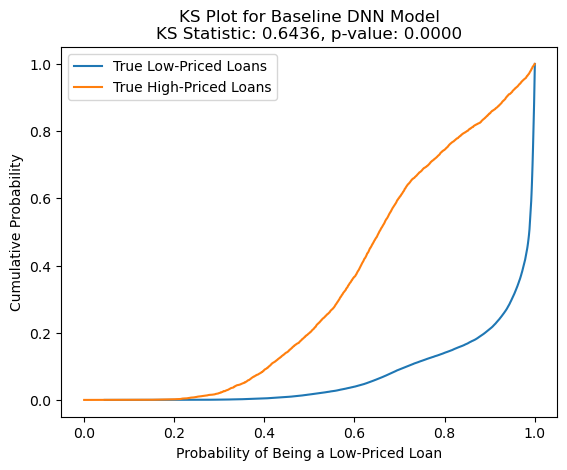

In [48]:
ks_plot(base_valid_pred, 'Baseline DNN')

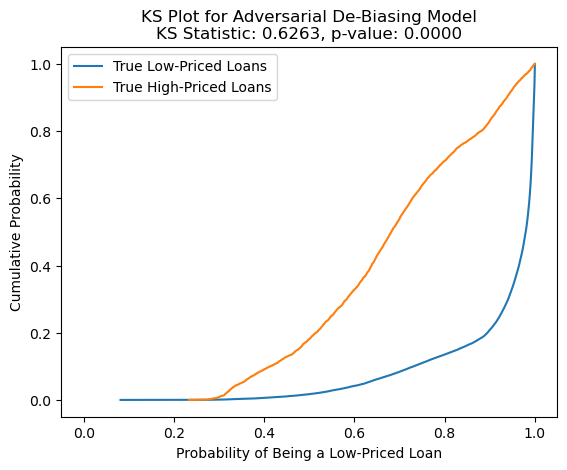

In [49]:
ks_plot(adb_valid_pred, 'Adversarial De-Biasing')

## Testing the Effectiveness of the Adversary

In [56]:
get_race_logloss(base_train_pred, base_valid_pred)

Black Log-Loss Train:    3.6836
Black Log-Loss Valid:    3.6750


In [57]:
get_race_logloss(adb_train_pred, adb_valid_pred)

Black Log-Loss Train:    3.4718
Black Log-Loss Valid:    3.4646


## Calculating and Comparing Disparities for the Two DNNs

## Standardized Mean Differences (SMDs)

In [58]:
base_smd = calculate_smd(valid, base_valid_pred)
base_smd

,Average Outcome,Difference in Average Outcome,Std. Dev. of Outcomes,SMD,Practically Significant
Group,,,,,
Black,0.816120,-0.090742,0.15607,-58.14195,Yes
White,0.906862,NaN,0.15607,NaN,


In [59]:
adb_smd = calculate_smd(valid, adb_valid_pred)
adb_smd

,Average Outcome,Difference in Average Outcome,Std. Dev. of Outcomes,SMD,Practically Significant
Group,,,,,
Black,0.827652,-0.077558,0.151898,-51.059366,Yes
White,0.905211,NaN,0.151898,NaN,


### Adverse Impact Ratios (AIRs)

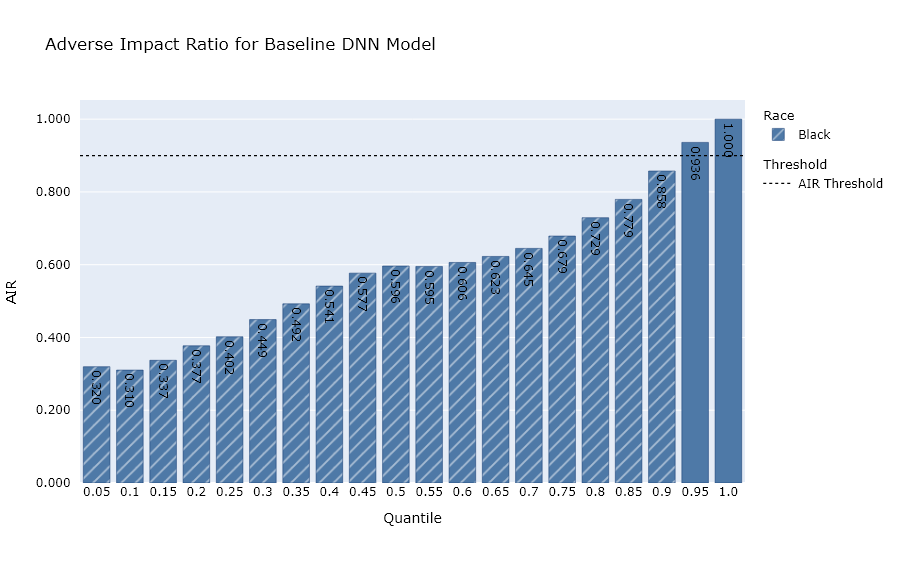

In [61]:
# AIRs for the DNN
base_air = calculate_quantile_air(valid, base_valid_pred)
fig = base_air.plot(group='Black')
fig.update_layout(title='Adverse Impact Ratio for Baseline DNN Model')
fig.show()

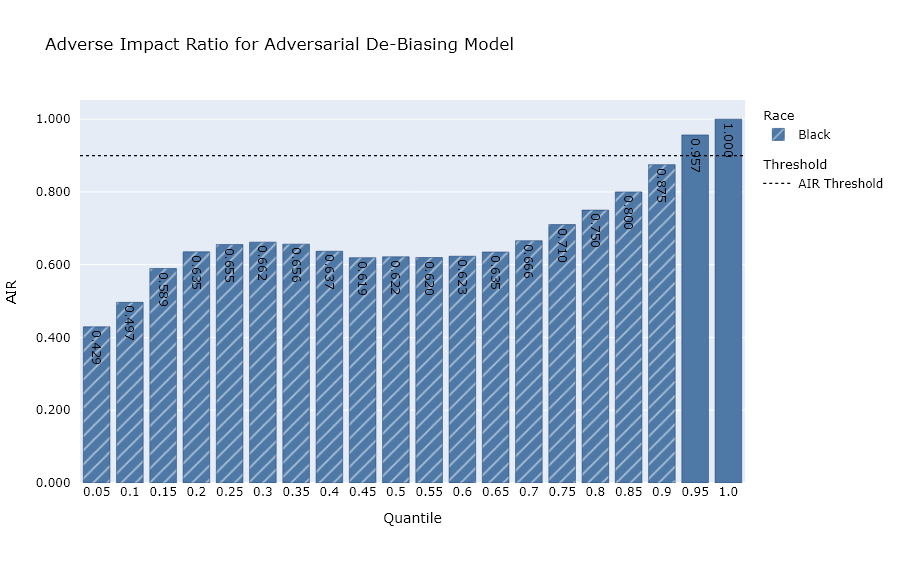

In [62]:
# AIRs for the ADB Model
adb_air = calculate_quantile_air(valid, adb_valid_pred)
fig = adb_air.plot(group='Black')
fig.update_layout(title='Adverse Impact Ratio for Adversarial De-Biasing Model')
fig.show()

In [64]:
air_compare = pd.concat(
    objs=(
        base_air.summary_table['Percent Favorable'].rename('Baseline DNN: Pct Favorable'),
        adb_air.summary_table['Percent Favorable'].rename('Adversarial De-Biasing: Pct Favorable'),
        base_air.summary_table['AIR'].rename('Baseline DNN: AIR'),
        adb_air.summary_table['AIR'].rename('Adversarial De-Biasing: AIR'),
    ),
    axis=1,
).drop(index='White', level=0)

In [66]:
air_compare['Percent Increase'] = air_compare['Adversarial De-Biasing: Pct Favorable'] - air_compare['Baseline DNN: Pct Favorable']

mask = (air_compare.reset_index('Quantile')['Quantile'] * 100 % 10 == 0).values
columns = ['Baseline DNN: Pct Favorable', 'Adversarial De-Biasing: Pct Favorable', 'Percent Increase']
air_compare.loc[mask, columns].style.format('{:0.2%}')

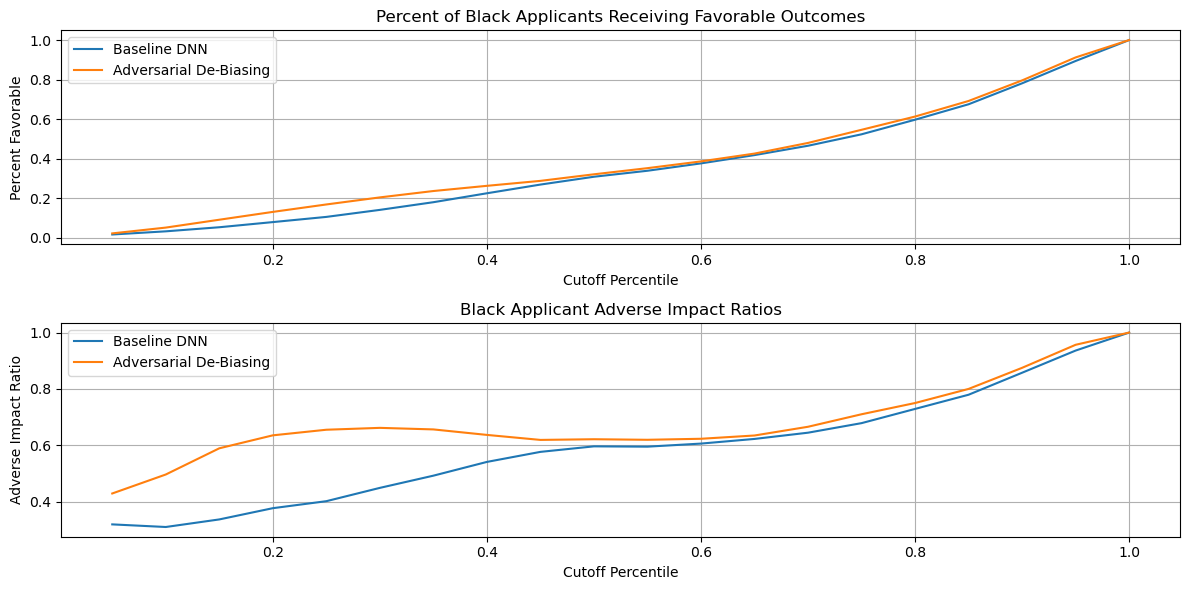

In [67]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
quantiles = [x[1] for x in air_compare.index.to_numpy()]

ax[0].plot(quantiles, air_compare[f'Baseline DNN: Pct Favorable'], label='Baseline DNN')
ax[0].plot(quantiles, air_compare[f'Adversarial De-Biasing: Pct Favorable'], label='Adversarial De-Biasing')
ax[0].set_xlabel('Cutoff Percentile')
ax[0].set_ylabel('Percent Favorable')
ax[0].set_title(f'Percent of Black Applicants Receiving Favorable Outcomes')
ax[0].legend()
ax[0].grid()

ax[1].plot(quantiles, air_compare[f'Baseline DNN: AIR'], label='Baseline DNN')
ax[1].plot(quantiles, air_compare[f'Adversarial De-Biasing: AIR'], label='Adversarial De-Biasing')
ax[1].set_xlabel('Cutoff Percentile')
ax[1].set_ylabel('Adverse Impact Ratio')
ax[1].set_title(f'Black Applicant Adverse Impact Ratios')
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

## Understanding Why Disparities Decreased in the Adversarial Debiasing Model

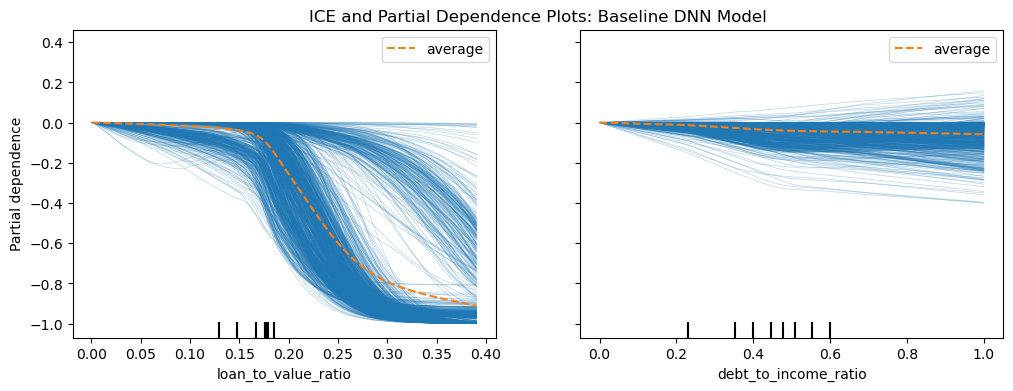

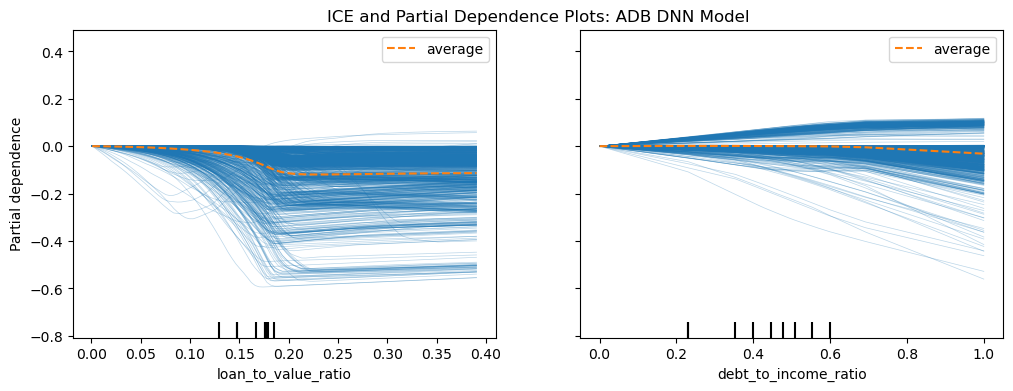

In [68]:
from sklearn.inspection import PartialDependenceDisplay

ice_features = ['loan_to_value_ratio', 'debt_to_income_ratio']
# ice_features = features
ice_features_index = [i for i, x in enumerate(features) if x in ice_features]

# ice_features = ['income']
fig, ax = plt.subplots(figsize=(12, 4))
# fig, ax = plt.subplots(figsize=(40, 8))
ax.set_title('ICE and Partial Dependence Plots: Baseline DNN Model')
PartialDependenceDisplay.from_estimator(
    estimator=base_model, 
    X=valid[features],
    features=ice_features_index,
    feature_names=features,
    kind='both', 
    centered=True, 
    ax=ax,
    percentiles=(0., 1.0),
    # n_cols=8,
)
plt.show()

# fig, ax = plt.subplots(figsize=(40, 8))
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title('ICE and Partial Dependence Plots: ADB DNN Model')
PartialDependenceDisplay.from_estimator(
    estimator=adb_model, 
    X=valid[features],
    features=ice_features_index,
    feature_names=features,
    kind='both', 
    centered=True, 
    ax=ax,
    # n_cols=8,
    percentiles=(0., 1.0),
)
plt.show()


In [157]:
cutoff_percentile = 0.75
base_score_cutoff = base_train_pred.quantile(1 - cutoff_percentile)
adb_score_cutoff = adb_train_pred.quantile(1 - cutoff_percentile)
print(f'Baseline Score Cutoff Value for {cutoff_percentile:0,.1%} Cutoff: {base_score_cutoff:.4f}')
print(f'ADB Score Cutoff Value for {cutoff_percentile:0,.1%} Cutoff:      {adb_score_cutoff:.4f}')

Baseline Score Cutoff Value for 75.0% Cutoff: 0.8747
ADB Score Cutoff Value for 75.0% Cutoff:      0.8854


In [158]:
def calculate_confusion_metrics(group_data, prediction, cutoff_value):
    recall = sd.custom_disparity_metric(
        group_data=group_data,
        protected_groups=['Black'],
        reference_groups=['White'],
        group_categories=['Race'],
        label=group_data[label],
        ratio_threshold=lambda x: x < 1,
        outcome=prediction > cutoff_value,
        metric=metrics.recall_score,
    ).summary_table
    recall = recall[['RECALL SCORE', 'Difference', 'Ratio']].rename(columns={'RECALL SCORE': 'Recall'})
    
    precision = sd.custom_disparity_metric(
        group_data=group_data,
        protected_groups=['Black'],
        reference_groups=['White'],
        group_categories=['Race'],
        label=group_data[label],
        ratio_threshold=lambda x: x < 1,
        outcome=prediction > cutoff_value,
        metric=metrics.precision_score,
    ).summary_table
    precision = precision[['PRECISION SCORE', 'Difference', 'Ratio']].rename(columns={'PRECISION SCORE': 'Precision'})
    return recall, precision

base_recall, base_precision = calculate_confusion_metrics(valid, base_valid_pred, base_score_cutoff)
adb_recall, adb_precision = calculate_confusion_metrics(valid, adb_valid_pred, adb_score_cutoff)

In [176]:
base_air_cutoff = sd.adverse_impact_ratio(
    group_data=valid,
    protected_groups=['Black'],
    reference_groups=['White'],
    group_categories=['Race'],
    outcome=base_valid_pred > base_score_cutoff,
    air_threshold=0.90,
    percent_difference_threshold=0,
).summary_table
adb_air_cutoff = sd.adverse_impact_ratio(
    group_data=valid,
    protected_groups=['Black'],
    reference_groups=['White'],
    group_categories=['Race'],
    outcome=adb_valid_pred > adb_score_cutoff,
    air_threshold=0.90,
    percent_difference_threshold=0,
).summary_table
print(
    f"AIR for Validation Set at Chosen Cutoff:"
    f"\nBaseline: {base_air_cutoff.loc['Black', 'AIR']:0,.2f}"
    f"\nADB:      {adb_air_cutoff.loc['Black', 'AIR']:0,.2f}"
    f"\n\nPercent Offer at Chosen Cutoff for Validation Set:"
    f"\nBaseline: {(base_valid_pred > base_score_cutoff).mean():0,.2%}"
    f"\nADB:      {(adb_valid_pred > adb_score_cutoff).mean():0,.2%}"
)

AIR for Validation Set at Chosen Cutoff:
Baseline: 0.68
ADB:      0.71

Percent Offer at Chosen Cutoff for Validation Set:
Baseline: 74.89%
ADB:      74.84%


In [177]:
recall_compare = pd.concat(
    objs=(
        base_recall,
        adb_recall,
    ),
    axis=1,
    keys=('Baseline DNN', 'Adversarial De-Biasing')
)
display(recall_compare.style.format('{:,.3f}',  na_rep='').set_caption('Comparison of Model Recall').set_table_styles([{
    'selector': 'caption',
    'props': 'text-align: center; font-size: 16pt; font-weight: bold; padding: 10px;'
}]))
precision_compare = pd.concat(
    objs=(
        base_precision,
        adb_precision,
    ),
    axis=1,
    keys=('Baseline DNN', 'Adversarial De-Biasing')
)
display(precision_compare.style.format('{:,.3f}',  na_rep='').set_caption('Comparison of Model Precision').set_table_styles([{
    'selector': 'caption',
    'props': 'text-align: center; font-size: 16pt; font-weight: bold; padding: 10px;'
}]))